# DSE 315 Project
## Deepfake classification
## Evaluation on unseen test set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
from transformers import AutoModelForImageClassification

# Load the image processor
from transformers import AutoImageProcessor

model_name = "microsoft/swinv2-small-patch4-window8-256"
image_processor = AutoImageProcessor.from_pretrained(model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Test set size: 3116
Test label distribution:
status
fake    1558
real    1558
Name: count, dtype: int64



Processing test images: 100%|██████████| 3116/3116 [04:02<00:00, 12.83it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Real     0.9934    0.9647    0.9788      1558
        Fake     0.9657    0.9936    0.9794      1558

    accuracy                         0.9791      3116
   macro avg     0.9795    0.9791    0.9791      3116
weighted avg     0.9795    0.9791    0.9791      3116

CONFUSION MATRIX


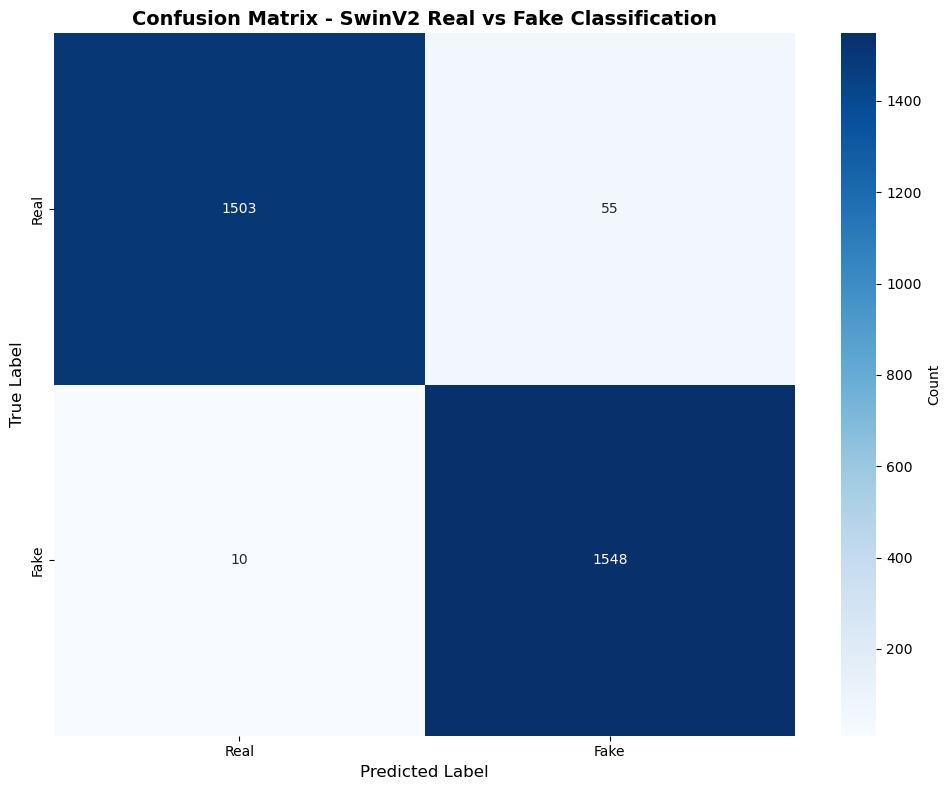


TN(Real predicted as Real):   1503
FP(Real predicted as Fake):  55
FN(Fake predicted as Real):  10
TP(Fake predicted as Fake):   1548


In [3]:
from PIL import Image
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from tqdm import tqdm

base_dir = 'celeb_df_preprocessed/Celeb-DF Preprocessed'
MODEL_CHECKPOINT = "./swinv2-real-vs-fake/checkpoint-5476" #the 4th epoch checkpoint

model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Set device to use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set model to evaluation mode

test_fake_path = os.path.join(base_dir, 'test', 'fake')
test_real_path = os.path.join(base_dir, 'test', 'real')

test_data = []

#create metadata for test set
test_fake_images = glob.glob(os.path.join(test_fake_path, '*.jpg'))
for img_path in test_fake_images[:1558]:
    test_data.append({
        'image_path': img_path,
        'label': 1,
        'status': 'fake'
    })
test_real_images = glob.glob(os.path.join(test_real_path, '*.jpg'))
for img_path in test_real_images:
    test_data.append({
        'image_path': img_path,
        'label': 0,
        'status': 'real'
    })

# Create DataFrame
test_df = pd.DataFrame(test_data)
print(f"\nTest set size: {len(test_df)}")
print(f"Test label distribution:\n{test_df['status'].value_counts()}\n")

def predict_image(image_path, model, processor, device):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}   
    
    # Make prediction
    with torch.no_grad(): # Disable gradient calculation (required for inference)
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    return predicted_class, probabilities[0].cpu().numpy()

y_true = []
y_pred = []
y_probs = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing test images"):
    img_path = row['image_path']
    true_label = row['label']
    predicted_class, probs = predict_image(img_path, model, image_processor, device)
    y_true.append(true_label)
    y_pred.append(predicted_class)
    y_probs.append(probs)

# Calculate metrics

print("CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake'], digits=4))

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')


# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("CONFUSION MATRIX")


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - SwinV2 Real vs Fake Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
print(f"\nTN(Real predicted as Real):   {cm[0][0]}")
print(f"FP(Real predicted as Fake):  {cm[0][1]}")
print(f"FN(Fake predicted as Real):  {cm[1][0]}")
print(f"TP(Fake predicted as Fake):   {cm[1][1]}")